<a href="https://colab.research.google.com/github/pramitpal/SRGAN_SPI/blob/main/SRGAN_test_for_single_pixel_imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
import os
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torchvision import models
import cv2
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
URL='https://www.dropbox.com/s/d1kjpkqklf0uw77/celeba.zip?dl=0'
ZIP_FILE='./data/celeba.zip'
%mkdir -p ./data/
!wget -N $URL -O $ZIP_FILE
!unzip $ZIP_FILE -d ./data/
!rm $ZIP_FILE

Streaming output truncated to the last 5000 lines.
  inflating: ./data/celeba/images/012465.jpg  
  inflating: ./data/celeba/images/089057.jpg  
  inflating: ./data/celeba/images/147796.jpg  
  inflating: ./data/celeba/images/192463.jpg  
  inflating: ./data/celeba/images/142818.jpg  
  inflating: ./data/celeba/images/148061.jpg  
  inflating: ./data/celeba/images/184432.jpg  
  inflating: ./data/celeba/images/201157.jpg  
  inflating: ./data/celeba/images/097288.jpg  
  inflating: ./data/celeba/images/130371.jpg  
  inflating: ./data/celeba/images/082864.jpg  
  inflating: ./data/celeba/images/017429.jpg  
  inflating: ./data/celeba/images/186077.jpg  
  inflating: ./data/celeba/images/126843.jpg  
  inflating: ./data/celeba/images/200381.jpg  
  inflating: ./data/celeba/images/012555.jpg  
  inflating: ./data/celeba/images/092238.jpg  
  inflating: ./data/celeba/images/008151.jpg  
  inflating: ./data/celeba/images/171418.jpg  
  inflating: ./data/celeba/images/155589.jpg  
  inflati

In [ ]:
celebData = '/content/data/celeba/images'
images = os.listdir(celebData)
imageList = images[:1500]

In [ ]:
len(imageList)

1500

In [ ]:
cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [ ]:
class Generator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,9,padding=4,bias=False)
        self.conv2 = n.Conv2d(64,64,3,padding=1,bias=False)
        self.conv3_1 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv3_2 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv4 = n.Conv2d(64,3,9,padding=4,bias=False)
        self.bn = n.BatchNorm2d(64)
        self.ps = n.PixelShuffle(2)
        self.prelu = n.PReLU()
        
    def forward(self,x):
        block1 = self.prelu(self.conv1(x))
        block2 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block1))))),block1)
        block3 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block2))))),block2)
        block4 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block3))))),block3)
        block5 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block4))))),block4)
        block6 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block5))))),block5)
        block7 = torch.add(self.bn(self.conv2(block6)),block1)
        block8 = self.prelu(self.ps(self.conv3_1(block7)))
        block9 = self.prelu(self.ps(self.conv3_2(block8)))
        block10 = self.conv4(block9)
        return block10

In [ ]:
gen = Generator().to(cuda)

#Uncomment below mentioned three lines if you have more than one gpu and want to use all of them
#ngpu=2
# if (cuda.type == 'cuda') and (ngpu > 1):
#     gen = n.DataParallel(gen, list(range(ngpu)))
summary(gen,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,552
             PReLU-2           [-1, 64, 64, 64]               1
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
             PReLU-5           [-1, 64, 64, 64]               1
            Conv2d-6           [-1, 64, 64, 64]          36,864
       BatchNorm2d-7           [-1, 64, 64, 64]             128
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
            PReLU-10           [-1, 64, 64, 64]               1
           Conv2d-11           [-1, 64, 64, 64]          36,864
      BatchNorm2d-12           [-1, 64, 64, 64]             128
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1, 64,

In [ ]:
class Discriminator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,3,padding=1,bias=False)
        self.conv2 = n.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.bn2 = n.BatchNorm2d(64)
        self.conv3 = n.Conv2d(64,128,3,padding=1,bias=False)
        self.bn3 = n.BatchNorm2d(128)
        self.conv4 = n.Conv2d(128,128,3,stride=2,padding=1,bias=False)
        self.bn4 = n.BatchNorm2d(128)
        self.conv5 = n.Conv2d(128,256,3,padding=1,bias=False)
        self.bn5 = n.BatchNorm2d(256)
        self.conv6 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn6 = n.BatchNorm2d(256)
        self.conv7 = n.Conv2d(256,512,3,padding=1,bias=False)
        self.bn7 = n.BatchNorm2d(512)
        self.conv8 = n.Conv2d(512,512,3,stride=2,padding=1,bias=False)
        self.bn8 = n.BatchNorm2d(512)
        self.fc1 = n.Linear(512*16*16,1024)
        self.fc2 = n.Linear(1024,1)
        self.drop = n.Dropout2d(0.3)
        
    def forward(self,x):
        block1 = f.leaky_relu(self.conv1(x))
        block2 = f.leaky_relu(self.bn2(self.conv2(block1)))
        block3 = f.leaky_relu(self.bn3(self.conv3(block2)))
        block4 = f.leaky_relu(self.bn4(self.conv4(block3)))
        block5 = f.leaky_relu(self.bn5(self.conv5(block4)))
        block6 = f.leaky_relu(self.bn6(self.conv6(block5)))
        block7 = f.leaky_relu(self.bn7(self.conv7(block6)))
        block8 = f.leaky_relu(self.bn8(self.conv8(block7)))
        block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
        block9 = f.leaky_relu(self.fc1(block8),)
#         block9 = block9.view(-1,block9.size(1)*block9.size(2)*block9.size(3))
        block10 = torch.sigmoid(self.drop(self.fc2(block9)))
        return block9,block10

In [ ]:
disc = Discriminator().to(cuda)
summary(disc,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
            Conv2d-2         [-1, 64, 128, 128]          36,864
       BatchNorm2d-3         [-1, 64, 128, 128]             128
            Conv2d-4        [-1, 128, 128, 128]          73,728
       BatchNorm2d-5        [-1, 128, 128, 128]             256
            Conv2d-6          [-1, 128, 64, 64]         147,456
       BatchNorm2d-7          [-1, 128, 64, 64]             256
            Conv2d-8          [-1, 256, 64, 64]         294,912
       BatchNorm2d-9          [-1, 256, 64, 64]             512
           Conv2d-10          [-1, 256, 32, 32]         589,824
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 512, 32, 32]       1,179,648
      BatchNorm2d-13          [-1, 512, 32, 32]           1,024
           Conv2d-14          [-1, 512,

In [ ]:
disc = Discriminator().to(cuda).float()
gen = Generator().to(cuda).float()

In [ ]:
vgg = models.vgg19(pretrained=True).to(cuda)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
gen_loss = n.BCELoss()
vgg_loss = n.MSELoss()
mse_loss = n.MSELoss()
disc_loss = n.BCELoss()

In [ ]:
gen_optimizer = optim.Adam(gen.parameters(),lr=0.0001)
disc_optimizer = optim.Adam(disc.parameters(),lr=0.0001)

In [ ]:
def loadImages(imageList,path,resize=False):
    images=[]
    for image in (imageList):
#         print(image)
        if resize:
            img = cv2.resize(cv2.imread(os.path.join(path,image)),(256,256)) 
        else:
            img = cv2.imread(os.path.join(path,image))
#         img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
#         print(img.shape)
        img = np.moveaxis(img, 2, 0)
#         print(img.shape)
        images.append(img)
    return np.array(images)

In [ ]:
def loadLRImages(imagelist,path):
    images=[]
    for image in (imagelist):
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(path,image)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
#         img = img.reshape(img.shape[2],img.shape[0],img.shape[1])
        img = np.moveaxis(img, 2, 0)
        images.append(img)
    return np.array(images)

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [ ]:
def imagePostProcess(imagedir,modelPath):
    imagelist=[]
#     images = os.listdir(imagedir)
    for img in imagedir:
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(hr_path,img)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
        imagelist.append(img)
    imagearray = np.array(imagelist)/255
#     imagearray = (imagedir)/255
    # imagearrayPT = np.reshape(imagearray,(len(imagelist),imagearray.shape[3],imagearray.shape[1],imagearray.shape[2]))
    imagearrayPT = np.moveaxis(imagearray,3,1)
    # print(imagearrayPT.shape)

    model = load_checkpoint(modelPath)
    im_tensor = torch.from_numpy(imagearrayPT).float()
    out_tensor = model(im_tensor)
    # print(out_tensor.shape)
    # out = np.reshape(out_tensor,[out_tensor.shape[0],out_tensor.shape[2],out_tensor.shape[3],out_tensor.shape[1]])
    out = out_tensor.numpy()
    out = np.moveaxis(out,1,3)
    # print(out.shape)
    out = np.clip(out,0,1)
    
    return out

In [ ]:
def show_samples(sample_images):
    figure, axes = plt.subplots(1, sample_images.shape[0], figsize = (10,10))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray((image_array * 255).astype('uint8'))
    plt.savefig(os.path.join(base_path,"out/SR")+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [ ]:
#change the batch-size based on your system memory

epochs=1000
batch_size=5

In [ ]:
import os 
base_path = os.getcwd()

#lr_path = os.path.join(base_path,"trainImages")
hr_path =celebData
#valid_path = os.path.join(base_path,"SR_valid")
weight_file = os.path.join(base_path,"SRPT_weights")
out_path = os.path.join(base_path,"out")

if not os.path.exists(weight_file):
    os.makedirs(weight_file)

if not os.path.exists(out_path):
    os.makedirs(out_path)

    
#LR_images_list = os.listdir(lr_path)
HR_images_list = imageList
batch_count = len(HR_images_list)//batch_size
batch_count

300

100%|██████████| 300/300 [05:58<00:00,  1.19s/it]


Epoch ::::  1  d1_loss ::: 5.0878610273562135  d2_loss :::0.7357180298143087
genLoss ::: 35.48005390458813  vggLoss ::: 0.11408663348605236  MeanLoss  ::: 0.013733709873631596


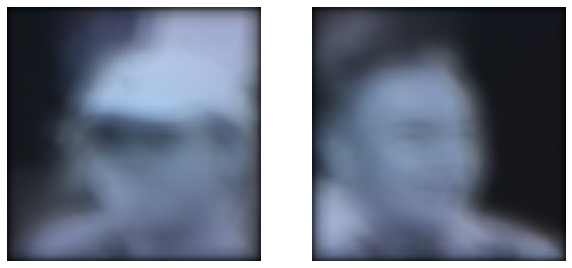

100%|██████████| 300/300 [05:56<00:00,  1.19s/it]


Epoch ::::  2  d1_loss ::: 0.80865603819984  d2_loss :::0.26177370618337015
genLoss ::: 49.80017916917801  vggLoss ::: 0.07299595004568497  MeanLoss  ::: 0.0036781781640214226


100%|██████████| 300/300 [05:56<00:00,  1.19s/it]


Epoch ::::  3  d1_loss ::: 0.29837372581240196  d2_loss :::0.2715988057112719
genLoss ::: 50.46770309925079  vggLoss ::: 0.0646606266995271  MeanLoss  ::: 0.002599154998315498


100%|██████████| 300/300 [05:57<00:00,  1.19s/it]


Epoch ::::  4  d1_loss ::: 0.4495602437987327  d2_loss :::0.2391346140537621
genLoss ::: 39.936148738761744  vggLoss ::: 0.06231545326610406  MeanLoss  ::: 0.00230494541542915


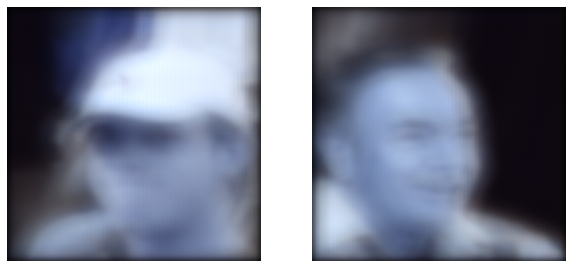

100%|██████████| 300/300 [05:58<00:00,  1.19s/it]


Epoch ::::  5  d1_loss ::: 0.2049584473831609  d2_loss :::0.21397570409999
genLoss ::: 29.16710341691971  vggLoss ::: 0.05877447680880626  MeanLoss  ::: 0.0019508318372148399


100%|██████████| 300/300 [05:57<00:00,  1.19s/it]


Epoch ::::  6  d1_loss ::: 0.1937247234895998  d2_loss :::0.198705781922288
genLoss ::: 27.9855384683609  vggLoss ::: 0.05678906768560409  MeanLoss  ::: 0.0017545483152692518


100%|██████████| 300/300 [05:59<00:00,  1.20s/it]


Epoch ::::  7  d1_loss ::: 0.5859979706235505  d2_loss :::0.3009416579293363
genLoss ::: 22.883783967395622  vggLoss ::: 0.055142601933330294  MeanLoss  ::: 0.0016039935650769622


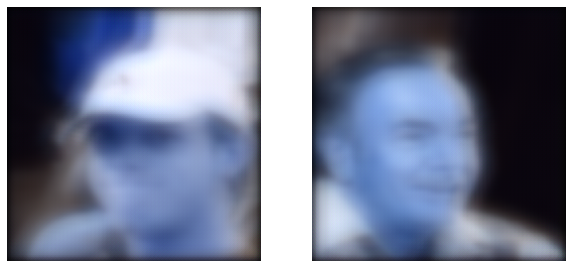

100%|██████████| 300/300 [05:59<00:00,  1.20s/it]


Epoch ::::  8  d1_loss ::: 0.24986279526516075  d2_loss :::0.2239576197172875
genLoss ::: 30.858143772681554  vggLoss ::: 0.05375777349496881  MeanLoss  ::: 0.0014637732137149822


100%|██████████| 300/300 [05:58<00:00,  1.20s/it]


Epoch ::::  9  d1_loss ::: 0.2103663403443229  d2_loss :::0.20102250155469453
genLoss ::: 37.38825120608012  vggLoss ::: 0.052593397436042626  MeanLoss  ::: 0.0013559034200928484


100%|██████████| 300/300 [05:59<00:00,  1.20s/it]


Epoch ::::  10  d1_loss ::: 0.20573556619769703  d2_loss :::0.20704578241005667
genLoss ::: 35.98970899422964  vggLoss ::: 0.05162478263179461  MeanLoss  ::: 0.0012751152348937467


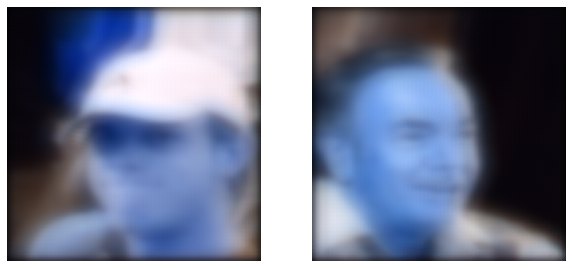

100%|██████████| 300/300 [05:59<00:00,  1.20s/it]


Epoch ::::  11  d1_loss ::: 0.24622030177624643  d2_loss :::0.24938163717855616
genLoss ::: 30.511893498102825  vggLoss ::: 0.05081705716128151  MeanLoss  ::: 0.001211164048096786


100%|██████████| 300/300 [06:00<00:00,  1.20s/it]


Epoch ::::  12  d1_loss ::: 0.26009918166779306  d2_loss :::0.24668456012795975
genLoss ::: 17.610904441078503  vggLoss ::: 0.0501191793444256  MeanLoss  ::: 0.001160063737964568


100%|██████████| 300/300 [06:01<00:00,  1.20s/it]


Epoch ::::  13  d1_loss ::: 0.219703512914654  d2_loss :::0.20645918672451136
genLoss ::: 14.82564181804657  vggLoss ::: 0.049536636266857385  MeanLoss  ::: 0.001120334716203312


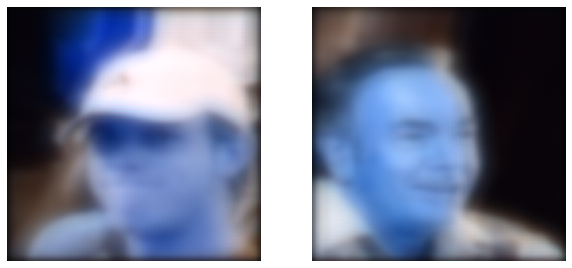

100%|██████████| 300/300 [06:00<00:00,  1.20s/it]


Epoch ::::  14  d1_loss ::: 0.20770676222975162  d2_loss :::0.2044174301617756
genLoss ::: 22.913566066424053  vggLoss ::: 0.04903454748292764  MeanLoss  ::: 0.0010892867646180094


100%|██████████| 300/300 [06:00<00:00,  1.20s/it]


Epoch ::::  15  d1_loss ::: 0.22422541899982515  d2_loss :::0.21310814532859937
genLoss ::: 21.736647719542187  vggLoss ::: 0.048614552586028974  MeanLoss  ::: 0.0010635432981265089


100%|██████████| 300/300 [06:00<00:00,  1.20s/it]


Epoch ::::  16  d1_loss ::: 0.2148914101357655  d2_loss :::0.21118142673440252
genLoss ::: 21.599668960173926  vggLoss ::: 0.04823790349066257  MeanLoss  ::: 0.0010385696122345205


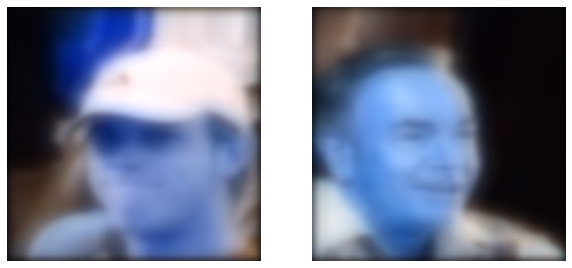

100%|██████████| 300/300 [06:01<00:00,  1.20s/it]


Epoch ::::  17  d1_loss ::: 0.20937456401431195  d2_loss :::0.2033277193077186
genLoss ::: 22.489162796338398  vggLoss ::: 0.047910306652386984  MeanLoss  ::: 0.0010161740189262977


100%|██████████| 300/300 [06:01<00:00,  1.20s/it]


Epoch ::::  18  d1_loss ::: 0.2051853604118624  d2_loss :::0.20750367986070398
genLoss ::: 22.030886668364207  vggLoss ::: 0.04761546860759457  MeanLoss  ::: 0.0009960784635040909


  8%|▊         | 24/300 [00:28<05:32,  1.20s/it]

In [ ]:
#batch_count=60
for epoch in range(epochs):
    d1loss_list=[]
    d2loss_list=[]
    gloss_list=[]
    vloss_list=[]
    mloss_list=[]
    
    for batch in tqdm(range(batch_count)):
        hr_imagesList = [img for img in HR_images_list[batch*batch_size:(batch+1)*batch_size]]
        lr_images = loadLRImages(hr_imagesList,hr_path)/255
        hr_images = loadImages(hr_imagesList,hr_path,True)/255
        
                
        disc.zero_grad()

        gen_out = gen(torch.from_numpy(lr_images).to(cuda).float())
        _,f_label = disc(gen_out)
        _,r_label = disc(torch.from_numpy(hr_images).to(cuda).float())
        d1_loss = (disc_loss(f_label,torch.zeros_like(f_label,dtype=torch.float)))
        d2_loss = (disc_loss(r_label,torch.ones_like(r_label,dtype=torch.float)))
        # d_loss = d1_loss+d2_loss
        d2_loss.backward()
        d1_loss.backward(retain_graph=True)
        # print(d1_loss,d2_loss)
#         d_loss.backward(retain_graph=True)
        disc_optimizer.step()
        

        gen.zero_grad()      
        g_loss = gen_loss(f_label.data,torch.ones_like(f_label,dtype=torch.float))
        v_loss = vgg_loss(vgg.features[:7](gen_out),vgg.features[:7](torch.from_numpy(hr_images).to(cuda).float()))
        m_loss = mse_loss(gen_out,torch.from_numpy(hr_images).to(cuda).float())
        
        generator_loss = g_loss + v_loss + m_loss
        # v_loss.backward(retain_graph=True)
        # m_loss.backward(retain_graph=True)
        # g_loss.backward()
        # print(generator_loss)

        generator_loss.backward()
        gen_optimizer.step()
        
        d1loss_list.append(d1_loss.item())
        d2loss_list.append(d2_loss.item())
        
        gloss_list.append(g_loss.item())
        vloss_list.append(v_loss.item())
        mloss_list.append(m_loss.item())

        
        
#         print("d1Loss ::: "+str((d1_loss.item()))+" d2Loss ::: "+str((d2_loss.item())))
#         print("gloss ::: "+str((g_loss.item()))+" vloss ::: "+str((v_loss.item()))+" mloss ::: "+str((m_loss.item())))
    print("Epoch ::::  "+str(epoch+1)+"  d1_loss ::: "+str(np.mean(d1loss_list))+"  d2_loss :::"+str(np.mean(d2loss_list)))
    print("genLoss ::: "+str(np.mean(gloss_list))+"  vggLoss ::: "+str(np.mean(vloss_list))+"  MeanLoss  ::: "+str(np.mean(mloss_list)))
    
    if(epoch%3==0):
        
        checkpoint = {'model': Generator(),
              'input_size': 64,
              'output_size': 256,
              'state_dict': gen.state_dict()}
        torch.save(checkpoint,os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
        torch.cuda.empty_cache()
        
        out_images = imagePostProcess(images[-2:],os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
#         print(out_images.shape)
#         test_images = loadLRImages(images[:-3],hr_path)/255
#         test_images = np.reshape(test_images,(test_images[0],test_images.shape[3],test_images.shape[1],test_images.shape[2]))
#         out_images = gen(torch.from_numpy(test_images).to(cuda).float())
#         out_images = np.reshape(out_images,(out_images[0],out_images[2],out_images[3],out_images[1]))
        show_samples(out_images)
        